In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import sys
sys.path.remove('/home/jovyan/.imgenv-vasilyev-0/lib/python3.7/site-packages')
sys.path.append('/home/jovyan/klenitskiy/repos/seqrec-experiments/')
sys.path.append('/home/jovyan/klenitskiy/repos/seqrec-datasets')
sys.path.append('/home/jovyan/klenitskiy/repos/')
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from nnsight import NNsight
from sklearn.feature_selection import chi2
from sklearn.metrics import explained_variance_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, IterableDataset

from dictionary_learning.dictionary import AutoEncoder, GatedAutoEncoder, JumpReluAutoEncoder, AutoEncoderNew
from dictionary_learning.trainers import StandardTrainer, GatedSAETrainer, TrainerTopK
from dictionary_learning.trainers.top_k import AutoEncoderTopK
from dictionary_learning.training import trainSAE

from seqrec_experiments.lightning.datasets import CausalLMDataset, PaddingCollateFn
from preprocessing.preparation import get_last_item, remove_last_item

from src.activations import extract_activations, get_block_activations, get_last_layer_activations, get_mlp_activations
from src.analyze import analyze_feature, compute_hidden_stats, features_vs_neuron_stats
from src.downstream import get_logit_diff_for_neuron, get_logit_diff_matrix
from src.sae import run_sae, SAEIterableDataset
from src.visualization import plot_activation_distr, plot_feature_vs_neuron, plot_neuron_fired_fraction, plot_num_active_neurons


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [3]:
ITEM_FEATURES_PATH = '/home/jovyan/klenitskiy/data/ml-1m/movies.csv'
DATA_PATH = 'data/ml-1m'
MODEL_PATH = 'models/ml-1m/gpt_64_2_2.pt'

## Prepare data

In [4]:
item_features = pd.read_csv(ITEM_FEATURES_PATH)
item_features = item_features.join(item_features.genres.str.get_dummies())
print(item_features.shape)
item_features.head()

(3883, 22)


,item_id,title,genres,year,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# item_features.to_csv('/home/jovyan/klenitskiy/research/sparse_autoencoders/results/ml-1m/item_features.csv', index=False)

In [6]:
item_features.loc[:, 'Action':].sum()

Action          503
Adventure       283
Animation       105
Children's      251
Comedy         1200
Crime           211
Documentary     127
Drama          1603
Fantasy          68
Film-Noir        44
Horror          343
Musical         114
Mystery         106
Romance         471
Sci-Fi          276
Thriller        492
War             143
Western          68
dtype: int64

In [7]:
train = pd.read_csv(os.path.join(DATA_PATH, 'validation.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

## Extract data for Sparse Autoencoder

In [8]:
model = torch.load(MODEL_PATH, weights_only=False)
model.eval()

GPT4Rec(
  (embed_layer): Embedding(3953, 64, padding_idx=0)
  (transformer_model): GPT2Model(
    (wte): Embedding(2, 64)
    (wpe): Embedding(128, 64)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (head): Linear(in_features=64, out_features=3953, bias=False)
)

In [9]:
MAX_LENGTH = 128
BATCH_SIZE_GPT = 256
NUM_WORKERS = 8

train_dataset = CausalLMDataset(train, max_length=MAX_LENGTH, time_col='timestamp')
test_dataset = CausalLMDataset(test, max_length=MAX_LENGTH, time_col='timestamp')

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE_GPT,
    shuffle=False, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE_GPT,
    shuffle=False, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())

batch_gpt = next(iter(train_loader))
print(batch_gpt['input_ids'].shape)

torch.Size([256, 128])


In [10]:
# get_block_activations, get_last_layer_activations, get_mlp_activations
get_activations_fn = get_block_activations
model.to('cuda')
activations_train = extract_activations(model, train_loader, get_activations_fn=get_activations_fn, layer_number=0)
activations_test = extract_activations(model, test_loader, get_activations_fn=get_activations_fn, layer_number=0)

100%|██████████| 3/3 [00:00<00:00,  7.56it/s]


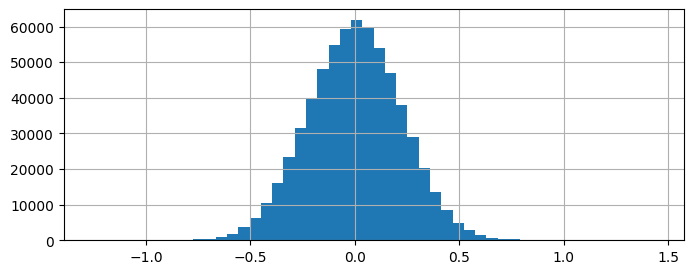

In [11]:
array = np.array(list(activations_train.activation))
fig = plot_activation_distr(array, low_value=array.min(), clip_quantile=1, figsize=(8, 3), sample_size=10000)

## Sparse Autoencoder training

In [12]:
BATCH_SIZE_SAE = 1024

sae_train_dataset = SAEIterableDataset(activations_train)
sae_train_loader = DataLoader(
    sae_train_dataset, batch_size=BATCH_SIZE_SAE,
    num_workers=NUM_WORKERS)

batch_sae = next(iter(sae_train_loader))
print(batch_sae.shape)

torch.Size([1024, 64])


In [13]:
len(activations_train) / BATCH_SIZE_SAE

177.546875

In [14]:
trainer_cfg = {
    "trainer": StandardTrainer,
    "dict_class": AutoEncoder,
    "activation_dim": 64,
    "dict_size": 512,
    "lr": 1e-3,
    "l1_penalty": 1e-1,
    "warmup_steps" : 100,
    "resample_steps" : None,
    "layer": "layer",
    "lm_name": "GPT"
}

# trainer_cfg = {
#     "trainer": GatedSAETrainer,
#     "dict_class": GatedAutoEncoder,
#     "activation_dim": 64,
#     "dict_size": 512,
#     "lr": 1e-3,
#     "l1_penalty": 1e-1,
#     "warmup_steps" : 100,
#     "resample_steps" : None,
#     "layer": "layer",
#     "lm_name": "GPT"
# }

# trainer_cfg = {
#     "trainer": TrainerTopK,
#     "activation_dim": 64,
#     "dict_size": 512,
#     "k": 50,
#     "decay_start": 3000,  # when does the lr decay start
#     "steps": 5000,
#     "layer": "layer",
#     "lm_name": "GPT"
# }

ae, logs = trainSAE(
    data=sae_train_loader,
    trainer_configs=[trainer_cfg],
    steps=5000,
    log_steps=200,
)

100%|██████████| 5000/5000 [00:14<00:00, 352.62it/s]


In [15]:
pd.DataFrame(logs)

,StandardTrainer-0/frac_variance_explained,StandardTrainer-0/l2_loss,StandardTrainer-0/mse_loss,StandardTrainer-0/sparsity_loss,StandardTrainer-0/loss,StandardTrainer-0/l0
0,-0.910203,2.895448,8.689014,29.163391,5.811787,250.325195
1,0.771168,0.815679,0.682228,4.239607,1.239640,53.190430
2,0.888029,0.570033,0.334232,4.339218,1.003954,53.267578
3,0.920871,0.479299,0.236608,4.469971,0.926296,58.261719
4,0.935385,0.437421,0.197305,4.542285,0.891649,61.369141
5,0.942404,0.412839,0.175929,4.539640,0.866803,63.536133
6,0.948724,0.385301,0.153556,4.569267,0.842228,65.460938
7,0.951956,0.376265,0.146120,4.618131,0.838078,67.262695
8,0.957659,0.361266,0.134743,4.740878,0.835353,69.171875
9,0.958731,0.347634,0.124675,4.688385,0.816472,70.973633


In [16]:
# torch.save(ae, os.path.join('results/ml-1m/gpt_64_2_2/sae_2048_block_0.pt'))

## Sparse Autoencoder analysis

In [17]:
%%time

reconstruction, hidden = run_sae(ae, activations_test,
                                 batch_size=BATCH_SIZE_SAE, num_workers=NUM_WORKERS)
print(reconstruction.shape, hidden.shape)

(49923, 64) (49923, 512)
CPU times: user 109 ms, sys: 275 ms, total: 383 ms
Wall time: 433 ms


In [18]:
results = activations_test.copy()
results['hidden'] = list(hidden)
results['reconstruction'] = list(reconstruction)

# results.to_parquet('results/ml-1m/gpt_64_2_2/activations_2048_block_0.parquet', index=False)

### Reconstruction error

In [19]:
activation_values = np.array(activations_test.activation.tolist())

print('explained variance', explained_variance_score(activation_values, reconstruction))
print('mae', mean_absolute_error(activation_values, reconstruction))
print('rmse', root_mean_squared_error(activation_values, reconstruction))

explained variance 0.9707026481628418
mae 0.028596887
rmse 0.03634657


### Hidden neurons analysis

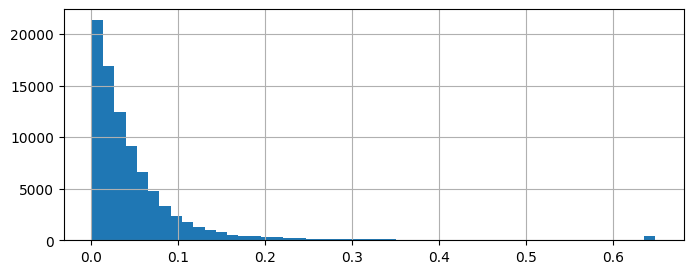

In [20]:
fig = plot_activation_distr(hidden, low_value=0.001, clip_quantile=0.995, figsize=(8, 3), sample_size=1000)

In [21]:
THRESHOLDS = [0, 0.1, 0.5, 1]

num_active_neurons, neuron_fired_fraction = compute_hidden_stats(hidden, thresholds=THRESHOLDS)
num_dead_neurons = (neuron_fired_fraction[0] == 0).sum()
print('num_dead_neurons', num_dead_neurons)

num_dead_neurons 1


In [22]:
num_active_neurons.describe()

,0.0,0.1,0.5,1.0
count,49923.000000,49923.000000,49923.000000,49923.000000
mean,88.456042,10.039421,0.728602,0.132805
std,9.759528,3.801868,0.672475,0.340251
min,49.000000,1.000000,0.000000,0.000000
25%,82.000000,7.000000,0.000000,0.000000
50%,88.000000,10.000000,1.000000,0.000000
75%,95.000000,12.000000,1.000000,0.000000
max,138.000000,35.000000,4.000000,2.000000


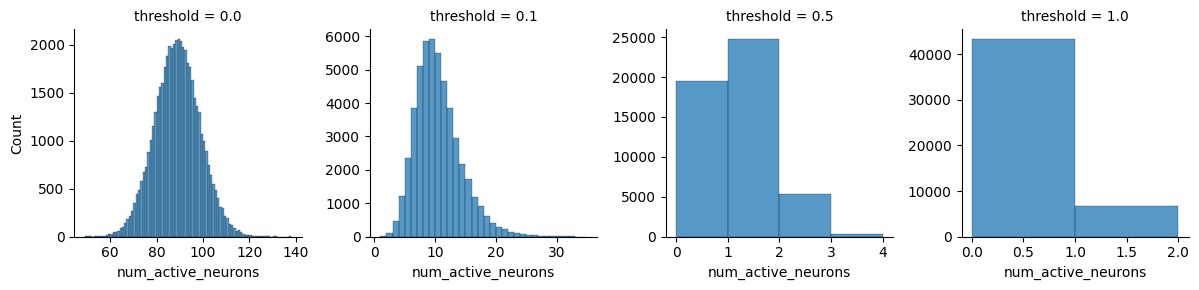

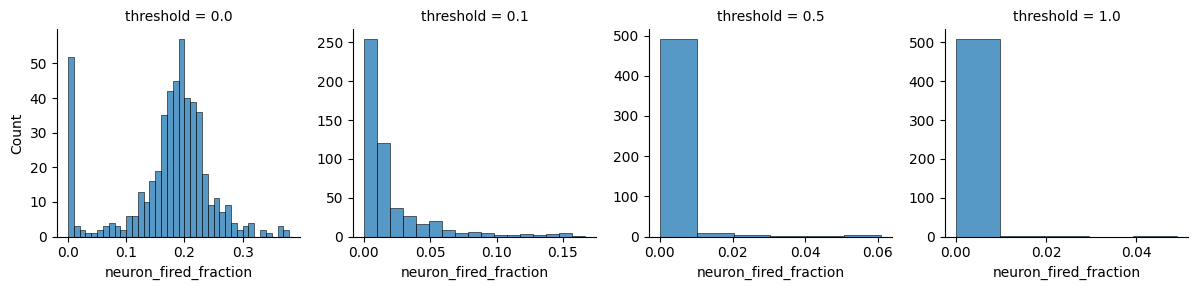

In [23]:
fig = plot_num_active_neurons(num_active_neurons, col_wrap=6, height=3, sharey=False, sharex=False)
fig = plot_neuron_fired_fraction(neuron_fired_fraction, col_wrap=6, height=3, cumulative=False, sharey=False, sharex=False)

### Correspondence to input features

In [24]:
features = pd.merge(activations_test, item_features, how='left')
feature_cols = features.loc[:, 'Action':].columns
features = features[feature_cols]
print(features.shape)
features.head()

(49923, 18)


,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [25]:
feature_name = 'Western'

In [26]:
chi2_stats = analyze_feature(hidden, features, feature_name=feature_name)

Analyze feature: Western
Number of examples with feature 1026
Fraction of examples with feature 0.02055164954029205
Top neurons according to chi2 statistics
160    8881.051612
376    3760.677855
98      221.071899
281     123.492414
146      86.650344
314      68.949403
119      41.973922
201      41.127068
327      41.052237
223      39.961675
Name: chi2, dtype: float64
Stats for top neuron
Neuron id 160
When feature is on:
Average neuron activation 0.56247085
Number of examples with fired neuron 1026
Fraction of examples with fired neuron 1.0
When feature is off:
Average neuron activation 0.02195028
Average top neuron activation for other features
Western        0.562471
War            0.050082
Action         0.036905
Fantasy        0.036426
Adventure      0.034921
Mystery        0.033823
Children's     0.032023
Musical        0.029798
Comedy         0.027727
Documentary    0.026760
dtype: float32


/home/jovyan/klenitskiy/research/sparse_autoencoders/src/visualization.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_plot['hidden'] = hidden[:, neuron_id]


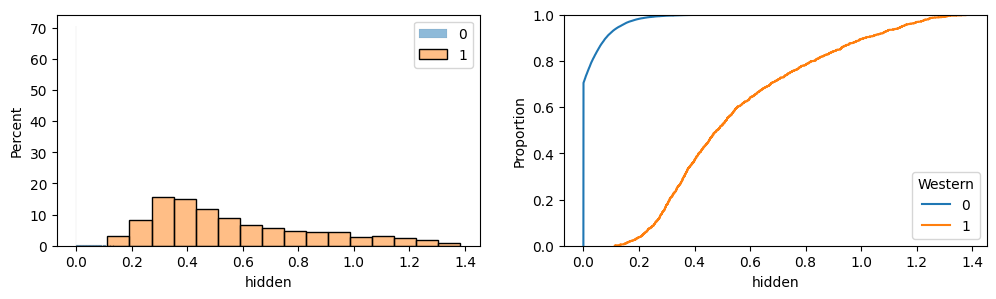

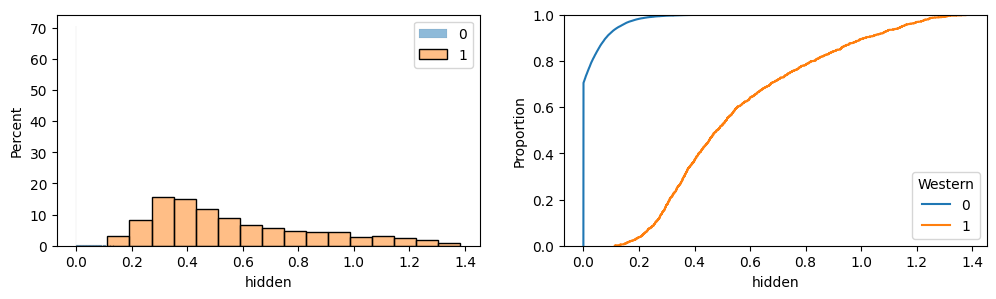

In [27]:
plot_feature_vs_neuron(hidden, features, feature_name,
                       neuron_id=chi2_stats.index[0],
                       figsize=(12, 3))

In [28]:
mean_neuron_activation, fraction_neuron_fired, neuron_feature_corr = features_vs_neuron_stats(hidden, features)

/home/jovyan/klenitskiy/envs/klenitskiy_seqrec/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jovyan/klenitskiy/envs/klenitskiy_seqrec/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [29]:
pd.set_option('display.max_columns', 50)

feature_to_sort = 'Western' 
# feature_to_sort = 'Animation'
# feature_to_sort = 'Action'
# feature_to_sort = 'Sci-Fi'
# feature_to_sort = 'Thriller'
# feature_to_sort = 'Romance'
# feature_to_sort = 'Fantasy'
# feature_to_sort = 'Horror'
mean_neuron_activation_top = mean_neuron_activation.sort_values(feature_to_sort, ascending=False).head(10)
mean_neuron_activation_top

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
160,0.036905,0.034921,0.016745,0.032023,0.027727,0.017082,0.026760,0.026632,0.036426,0.018393,0.020923,0.029798,0.033823,0.019315,0.017628,0.016580,0.050082,0.562471
376,0.005002,0.005142,0.006374,0.007698,0.004950,0.003223,0.017348,0.006100,0.008563,0.001059,0.003543,0.005045,0.003919,0.000869,0.002091,0.002386,0.008450,0.168265
281,0.039246,0.034659,0.022396,0.037155,0.045009,0.034340,0.005022,0.039038,0.037692,0.027022,0.074328,0.038742,0.023912,0.025527,0.050045,0.029099,0.038047,0.114919
170,0.147870,0.175067,0.082322,0.117794,0.111145,0.126116,0.081092,0.146795,0.191295,0.106405,0.120382,0.097435,0.097883,0.170792,0.154086,0.101156,0.235654,0.097097
128,0.241584,0.182784,0.008610,0.017896,0.025835,0.100605,0.004600,0.042559,0.055774,0.003029,0.040656,0.012356,0.031869,0.050384,0.104381,0.119107,0.110558,0.095571
407,0.132269,0.157400,0.027364,0.050802,0.034843,0.039194,0.002637,0.033964,0.107869,0.090672,0.092009,0.018933,0.061688,0.020446,0.403147,0.103431,0.062616,0.076879
201,0.046678,0.148574,0.050985,0.082726,0.018163,0.014693,0.001285,0.013648,0.105711,0.026067,0.008364,0.035481,0.009545,0.022409,0.035950,0.016431,0.027635,0.060847
314,0.020002,0.063041,0.027429,0.091817,0.018726,0.011432,0.005864,0.006404,0.271251,0.008569,0.005807,0.022792,0.010415,0.014782,0.023709,0.007822,0.015442,0.055891
158,0.006947,0.008591,0.064838,0.034686,0.068130,0.019031,0.030468,0.018969,0.008325,0.004041,0.011409,0.025541,0.006886,0.028662,0.006349,0.007102,0.011650,0.055026
271,0.049262,0.047210,0.047288,0.042321,0.049948,0.055420,0.047826,0.047691,0.047633,0.049120,0.055641,0.042507,0.054752,0.044752,0.053730,0.061210,0.045406,0.053164


In [30]:
# fraction_neuron_fired.loc[mean_neuron_activation_top.index]
fraction_neuron_fired.sort_values(feature_to_sort, ascending=False).head(10)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
160,0.342006,0.331220,0.267389,0.367337,0.288292,0.287613,0.350282,0.292682,0.416537,0.275711,0.332445,0.349798,0.419187,0.287927,0.221109,0.263916,0.422483,1.000000
376,0.103999,0.108615,0.219075,0.230402,0.113826,0.124402,0.418079,0.146484,0.251690,0.038293,0.124926,0.161203,0.117831,0.029915,0.075623,0.086853,0.237880,0.765107
314,0.265430,0.492074,0.326531,0.542211,0.213921,0.179426,0.135593,0.119256,0.980239,0.295405,0.179988,0.340817,0.265381,0.204193,0.271441,0.194932,0.270378,0.567251
281,0.300687,0.279669,0.176593,0.243970,0.295858,0.293993,0.064972,0.283088,0.288092,0.286652,0.413262,0.268523,0.201251,0.270566,0.369225,0.278103,0.275972,0.521442
98,0.221598,0.251964,0.152436,0.281156,0.225579,0.103402,0.019774,0.095588,0.252730,0.004376,0.089106,0.172878,0.114181,0.253072,0.184800,0.136994,0.133724,0.483431
243,0.486806,0.574638,0.315285,0.345226,0.362439,0.293461,0.567797,0.354722,0.530941,0.327133,0.379811,0.330040,0.179353,0.321848,0.519344,0.145874,0.339638,0.483431
424,0.347402,0.336320,0.359017,0.335176,0.306227,0.251196,0.279661,0.288775,0.351014,0.344639,0.305506,0.277054,0.298749,0.296207,0.387505,0.318064,0.299947,0.471735
201,0.348289,0.717161,0.486464,0.528894,0.165219,0.099149,0.039548,0.133444,0.571503,0.179431,0.062759,0.299506,0.082899,0.201522,0.297734,0.137752,0.258657,0.469786
60,0.362776,0.361130,0.353186,0.413568,0.393712,0.251196,0.398305,0.368336,0.370255,0.412473,0.381883,0.366412,0.392596,0.333868,0.351070,0.424410,0.387054,0.461988
327,0.326853,0.411165,0.249063,0.206533,0.246035,0.258905,0.237288,0.134076,0.342174,0.222101,0.143872,0.257746,0.281543,0.232238,0.339301,0.224821,0.212307,0.450292


In [31]:
# neuron_feature_corr.loc[mean_neuron_activation_top.index]
neuron_feature_corr.sort_values(feature_to_sort, ascending=False).head(10)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
160,0.023285,0.007624,-0.036410,-0.003028,-0.039484,-0.045288,-0.005285,-0.046695,0.006691,-0.019887,-0.032462,-0.006996,0.001517,-0.057327,-0.066865,-0.077947,0.048199,0.761445
376,-0.037887,-0.024005,-0.005340,0.003904,-0.047430,-0.031943,0.023924,-0.023005,0.007496,-0.023544,-0.027732,-0.013164,-0.018472,-0.074655,-0.062644,-0.064448,0.009781,0.652336
98,0.075932,0.069611,-0.022916,0.071582,0.101554,-0.041157,-0.025765,-0.118359,0.020730,-0.043169,-0.056848,-0.000197,-0.031574,0.061277,0.022637,-0.044214,-0.022844,0.247646
146,0.076878,-0.003041,-0.049611,-0.037102,-0.015303,0.057401,-0.004512,-0.014875,0.017369,-0.001556,-0.032422,-0.047181,0.016273,-0.088158,0.080132,-0.021408,0.018588,0.191904
327,0.159402,0.205050,0.021987,0.000287,0.050812,0.017924,-0.006360,-0.133702,0.055857,-0.006142,-0.040010,0.046581,0.030236,0.008867,0.151514,-0.000859,-0.014793,0.127375
223,-0.094973,-0.074943,-0.005394,0.046744,0.103706,-0.004640,0.008718,0.040438,-0.024922,-0.025428,-0.021127,0.053416,0.019144,-0.046320,-0.115924,-0.074986,-0.035366,0.120996
480,-0.110050,0.077429,0.114863,0.177681,-0.036525,-0.027313,-0.023682,0.016412,0.039023,-0.016712,-0.056402,0.185030,-0.012598,0.016196,-0.086921,-0.088938,0.024598,0.112865
261,0.022984,0.008661,-0.024529,-0.012726,-0.052253,0.033629,-0.011128,0.057297,-0.013109,-0.026673,-0.049600,-0.026406,0.095836,-0.059851,0.031153,0.032877,-0.038226,0.110972
137,0.049277,0.064032,-0.057120,-0.004917,-0.003650,-0.031002,-0.022678,-0.023705,0.007005,-0.003114,0.031854,-0.016529,-0.005318,-0.039365,-0.074271,-0.017498,0.057658,0.092680
339,-0.028869,0.028073,-0.006379,-0.024519,-0.072105,-0.089490,-0.012020,0.089478,-0.006079,-0.033226,-0.071761,0.026366,0.030911,0.021630,-0.045166,-0.004671,0.007582,0.092097


In [32]:
correlation_max = neuron_feature_corr.max(axis=0).round(3).rename('max correlation')
fraction_max = fraction_neuron_fired.max(axis=0).round(3).rename('max fraction')
mean_activation_max = mean_neuron_activation.max(axis=0).round(3).rename('max mean activation')
max_by_feature = correlation_max.to_frame().join(fraction_max).join(mean_activation_max)
max_by_feature

,max correlation,max fraction,max mean activation
Action,0.564,0.683,0.242
Adventure,0.575,0.717,0.183
Animation,0.694,0.972,0.455
Children's,0.632,0.877,0.329
Comedy,0.502,0.610,0.158
Crime,0.666,0.920,0.298
Documentary,0.687,0.994,0.298
Drama,0.432,0.555,0.157
Fantasy,0.800,0.996,0.303
Film-Noir,0.799,0.993,0.524


In [33]:
max_by_feature.mean()

max correlation        0.657611
max fraction           0.863833
max mean activation    0.313556
dtype: float64

## Downstream effects

In [35]:
neuron_id = mean_neuron_activation_top.index[0]
logit_diff_neuron = get_logit_diff_for_neuron(model, ae, item_features, neuron_id, feature_cols)
logit_diff_neuron_feature = logit_diff_neuron[(item_features[feature_to_sort] == 1).values]

In [37]:
logit_diff_neuron.sort_values('logit_diff', ascending=False).head(10)

,logit_diff,title,features
952,0.653101,Angel and the Badman (1947),Western
2853,0.648516,Hang 'em High (1967),Western
995,0.640523,"Davy Crockett, King of the Wild Frontier (1955)",Western
2332,0.626956,Pale Rider (1985),Western
454,0.613636,Geronimo: An American Legend (1993),Drama|Western
1859,0.608454,Cimarron (1931),Western
379,0.603964,Wyatt Earp (1994),Western
3425,0.600823,True Grit (1969),Adventure|Western
2852,0.595054,High Plains Drifter (1972),Western
3242,0.590540,"Man from Laramie, The (1955)",Western


In [39]:
logit_diff_neuron.sort_values('logit_diff').head(10)

,logit_diff,title,features
56,-0.334105,Home for the Holidays (1995),Drama
2251,-0.331008,Apt Pupil (1998),Drama|Thriller
2815,-0.330660,Dog Park (1998),Comedy|Romance
227,-0.329934,Dolores Claiborne (1994),Drama|Thriller
60,-0.320580,Eye for an Eye (1996),Drama|Thriller
596,-0.310782,Love and a .45 (1994),Thriller
825,-0.308043,Chain Reaction (1996),Action|Adventure|Thriller
1331,-0.305876,Albino Alligator (1996),Crime|Thriller
226,-0.301416,Death and the Maiden (1994),Drama|Thriller
1161,-0.298529,Enchanted April (1991),Drama


In [41]:
print(logit_diff_neuron_feature.logit_diff.mean())
logit_diff_neuron_feature.sort_values('logit_diff', ascending=False)

0.44739416


,logit_diff,title,features
952,0.653101,Angel and the Badman (1947),Western
2853,0.648516,Hang 'em High (1967),Western
995,0.640523,"Davy Crockett, King of the Wild Frontier (1955)",Western
2332,0.626956,Pale Rider (1985),Western
454,0.613636,Geronimo: An American Legend (1993),Drama|Western
...,...,...,...
1102,-0.030099,Tashunga (1995),Adventure|Western
1365,-0.030607,Terror in a Texas Town (1958),Western
3538,-0.036194,One Little Indian (1973),Comedy|Drama|Western
3532,-0.042916,"Castaway Cowboy, The (1974)",Comedy|Western


In [42]:
logit_diffs = get_logit_diff_matrix(model, ae, item_features, features)
print(logit_diffs.shape)
logit_diffs.sort_values(feature_to_sort, ascending=False).head(10)

(512, 18)


,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
160,0.001747,0.024592,-0.013164,0.026546,0.000493,-0.020991,-0.009248,-0.030349,0.067777,0.041090,0.034541,0.034174,0.067425,-0.022142,0.013763,-0.051573,0.087185,0.447394
376,-0.091057,-0.055074,0.038336,0.022484,-0.017286,-0.024864,0.030173,-0.033756,0.020048,0.060116,0.052835,0.043153,0.018116,-0.086237,-0.021547,-0.073089,0.059035,0.360398
76,0.106867,0.185545,0.177119,0.242360,0.075314,-0.028667,0.073912,0.015254,0.080504,0.020703,0.229165,0.114460,-0.007444,0.006582,0.108326,0.026409,0.061806,0.199720
467,0.069559,0.050096,-0.098332,-0.037253,0.013501,0.065083,0.094324,0.052857,0.051244,0.143290,0.092128,-0.016320,0.126256,0.042516,0.055722,0.061386,0.100634,0.194266
396,0.002672,0.011641,-0.034552,-0.006188,0.005329,-0.007577,0.081954,0.073381,-0.095919,0.060885,-0.011831,0.058046,-0.020103,0.019072,-0.031827,-0.016364,0.106626,0.169160
27,0.023623,-0.016428,-0.086481,-0.078770,-0.065060,-0.029332,-0.081732,0.003775,0.046463,-0.028156,-0.114986,-0.016691,-0.001943,0.011456,-0.064835,-0.042108,0.315587,0.161978
241,-0.007202,0.021710,0.069197,0.049450,0.006272,0.016836,0.082420,0.041018,0.024724,0.148882,-0.047543,0.082863,0.052098,0.028292,0.009804,0.006944,0.061365,0.161263
63,-0.112315,-0.080017,0.060944,0.044196,0.031835,-0.022580,0.073621,0.028939,-0.029762,-0.017446,-0.043845,0.099754,0.025845,0.056036,-0.118409,-0.029317,0.006725,0.153086
112,0.047977,0.145403,0.072445,0.112675,0.055273,-0.027781,-0.068287,-0.036695,0.191338,0.029463,-0.029602,0.072856,0.053970,0.075296,-0.007201,-0.033115,0.051805,0.151272
314,0.031864,0.169243,0.150357,0.191477,-0.027320,-0.041521,-0.103224,-0.085312,0.433443,0.039131,-0.053536,0.083036,0.045959,-0.036642,0.066409,-0.040305,0.045510,0.150468


In [44]:
logit_diffs_max = logit_diffs.max(axis=0).round(3).rename('logit diff max')
logit_diffs_min = logit_diffs.min(axis=0).round(3).rename('logit diff nin')
logit_diffs_min_max = logit_diffs_max.to_frame().join(logit_diffs_min)
logit_diffs_min_max

,logit diff max,logit diff nin
Action,0.302,-0.164
Adventure,0.284,-0.170
Animation,0.437,-0.287
Children's,0.353,-0.234
Comedy,0.200,-0.131
Crime,0.262,-0.193
Documentary,0.326,-0.191
Drama,0.129,-0.123
Fantasy,0.433,-0.283
Film-Noir,0.497,-0.347


## Intervention

In [45]:
user_id = np.random.choice(test.user_id.unique())
print(user_id)

502


In [46]:
example_input = test[test.user_id == user_id]
example_dataset = CausalLMDataset(example_input, max_length=MAX_LENGTH, time_col='timestamp')
example_loader = DataLoader(example_dataset, batch_size=1, collate_fn=PaddingCollateFn())
example = next(iter(example_loader))

In [48]:
model.eval()
# model_outputs_before = model(example['input_ids'], example['attention_mask'])
model_outputs_before = model(example['input_ids'].to('cuda'), example['attention_mask'].to('cuda'))

In [49]:
neuron_id = mean_neuron_activation_top.index[0]
print(neuron_id)

160


In [50]:
layer = 'block'  # block, mlp or last
layer_number = 0
step = -1


nsight_model = NNsight(model)


with nsight_model.trace(example['input_ids'], example['attention_mask']) as tracer:

    if layer == 'block':
        layer_output = nsight_model.transformer_model.h[layer_number].output[0]
    elif layer == 'mlp':
        layer_output = nsight_model.transformer_model.h[layer_number].mlp.output
    elif layer == 'last':
        layer_output = nsight_model.transformer_model.output.last_hidden_state
        
    activations = layer_output[0, step, :]
    latent_features = ae.encode(activations)
    
    latent_features[neuron_id] = 10
    
    reconstructed_activations = ae.decode(latent_features)
    layer_output[0, step, :] = reconstructed_activations
    
    model_outputs_after = nsight_model.head.output.save()

print(model_outputs_after.shape)

torch.Size([1, 23, 3953])


In [51]:
print(model_outputs_before[0, -1, :].mean())
print(model_outputs_after[0, -1, :].mean())

tensor(-2.4366, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.1011, device='cuda:0', grad_fn=<MeanBackward0>)


In [52]:
print(model_outputs_before[0, -1, :][item_features[item_features[feature_to_sort] == 1].item_id.values].mean())
print(model_outputs_after[0, -1, :][item_features[item_features[feature_to_sort] == 1].item_id.values].mean())

tensor(-2.1437, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3022, device='cuda:0', grad_fn=<MeanBackward0>)


In [53]:
# model_outputs_before[0, -1, :][item_features[item_features[feature_to_sort] == 1].item_id.values]

In [54]:
# model_outputs_after[0, -1, :][item_features[item_features[feature_to_sort] == 1].item_id.values]

In [55]:
preds_after = pd.DataFrame({'item_id': range(3953), 'model_output': model_outputs_after[0, -1, :].detach().cpu().numpy()})
preds_after = pd.merge(preds_after, item_features)
preds_after.sort_values('model_output', ascending=False).head(10)

,item_id,model_output,title,genres,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
2853,2922,8.440318,Hang 'em High (1967),Western,1967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2852,2921,8.162895,High Plains Drifter (1972),Western,1972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2332,2401,8.117605,Pale Rider (1985),Western,1985,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
379,383,8.028496,Wyatt Earp (1994),Western,1994,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3425,3494,7.899391,True Grit (1969),Adventure|Western,1969,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1246,1266,7.897766,Unforgiven (1992),Western,1992,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3612,3681,7.818483,For a Few Dollars More (1965),Western,1965,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3439,3508,7.760227,"Outlaw Josey Wales, The (1976)",Western,1976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
549,553,7.743779,Tombstone (1993),Western,1993,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
586,590,7.737936,Dances with Wolves (1990),Adventure|Drama|Western,1990,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [56]:
preds_before = pd.DataFrame({'item_id': range(3953), 'model_output': model_outputs_before[0, -1, :].detach().cpu().numpy()})
preds_before = pd.merge(preds_before, item_features)
preds_before.sort_values('model_output', ascending=False).head(10)

,item_id,model_output,title,genres,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1656,1704,7.525149,Good Will Hunting (1997),Drama,1997,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
148,150,6.965433,Apollo 13 (1995),Drama,1995,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1959,2028,6.909068,Saving Private Ryan (1998),Action|Drama|War,1998,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
293,296,6.868584,Pulp Fiction (1994),Crime|Drama,1994,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
33,34,6.759491,Babe (1995),Children's|Comedy|Drama,1995,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
589,593,6.568315,"Silence of the Lambs, The (1991)",Drama|Thriller,1991,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
35,36,6.423072,Dead Man Walking (1995),Drama,1995,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
604,608,6.392668,Fargo (1996),Crime|Drama|Thriller,1996,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
315,318,6.369921,"Shawshank Redemption, The (1994)",Drama,1994,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1195,1213,6.272851,GoodFellas (1990),Crime|Drama,1990,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


## Collect examples

In [57]:
from tqdm import tqdm

dead_neurons = []

for neuron_id in tqdm(range(hidden.shape[1])):
    
    neuron = activations_test[['user_id', 'item_id']]
    neuron['activation'] = hidden[:, neuron_id]

    active = neuron[neuron.activation > 0.1]
    if len(active) > 0:
        user_ids = active.groupby('user_id').activation.max().sort_values(ascending=False).head(30).index
        top_examples = neuron[neuron.user_id.isin(user_ids)]
        # top_examples.to_csv(f'activations/ml-1m/64_2_2_layer_0/neuron_{neuron_id}.csv', index=False)
    else:
        dead_neurons.append(neuron_id)

100%|██████████| 512/512 [00:01<00:00, 483.43it/s]


In [58]:
print(dead_neurons)

[13, 17, 22, 44, 52, 63, 78, 92, 97, 101, 105, 120, 131, 135, 140, 151, 183, 190, 191, 195, 238, 259, 273, 286, 300, 325, 328, 329, 336, 337, 342, 347, 354, 357, 384, 389, 392, 397, 413, 421, 429, 440, 441, 452, 454, 455, 461, 464, 467, 484, 498, 510]


In [71]:
neuron_id = 15

neuron = activations_test[['user_id', 'item_id']]
neuron['activation'] = hidden[:, neuron_id]

active = neuron[neuron.activation > 0.1]
if len(active) > 0:
    user_ids = active.groupby('user_id').activation.max().sort_values(ascending=False).head(30).index
    top_examples = neuron[neuron.user_id.isin(user_ids)]

In [72]:
top_examples

,user_id,item_id,activation
250,5,1719,0.001167
251,5,50,0.088134
252,5,860,0.000000
253,5,1192,0.110725
254,5,2571,0.109920
...,...,...,...
48569,590,1584,0.029785
48570,590,341,0.032167
48571,590,319,0.048164
48572,590,1966,0.132690


In [73]:
active.groupby('user_id').activation.max().sort_values(ascending=False).head(30)

user_id
590    0.226584
331    0.221183
167    0.215970
135    0.209160
265    0.207197
117    0.205597
283    0.197991
17     0.190520
278    0.188022
304    0.187320
46     0.182517
225    0.181709
71     0.175109
571    0.174823
161    0.173298
504    0.172780
546    0.169707
58     0.166386
406    0.165279
293    0.165146
362    0.164065
352    0.163986
45     0.163800
214    0.163677
252    0.162201
195    0.162161
537    0.162059
301    0.159012
5      0.158708
173    0.158425
Name: activation, dtype: float32

In [74]:
# pd.set_option('display.max_rows', 128)
# neuron[neuron.user_id == 18]